# Creative machine learning - Neural networks

### Author: Philippe Esling (esling@ircam.fr)

In this course we will cover
1. A [quick introduction](#intro) on the principles of neural networks
2. An implementation for a [single neuron](#neuron) in Numpy and JAX.
3. An exercise on [multi-layer perceptron (MLP)](#mlp) through manual derivation.
4. An introduction on [using Pytorch](#pytorch) for defining networks
5. An exercise on [audio classification](#audio) using an MLP with Pytorch.

Exercise completed by:

Megha Sharma, 48-226465

meghas@g.ecc.u-tokyo.ac.jp

### Colab-specific cell for imports

This is the *colab version* of the course, please evaluate the following cell right away in order to set up the missing libraries in the environment.

In [1]:
!pip install distrax
!git clone https://github.com/acids-ircam/cml.git "cml"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.0/318.0 kB 24.4 MB/s eta 0:00:00
Cloning into 'cml'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 66 (delta 27), reused 60 (delta 21), pack-reused 0
Unpacking objects: 100% (66/66), 29.40 KiB | 1.55 MiB/s, done.


<a id="intro"></a>
# Introducing neural networks

In this tutorial, we will cover more advanced models known as *neural networks*. The tutorial starts by performing a simple **single neuron** discrimination of two random distributions. We will exhibit the manual implementation using Numpy, and then simplify it with JAX. Then, we will study the typical **XOR problem** by using a more advanced 2-layer **perceptron**. Finally, we generalize the use of neural networks in order to perform classification on a given set of audio files, using the PyTorch library, which will provide simplified implementation.

We are going to use relatively _low-level_ libraries to perform the first exercises (implementing your own neurons). To observe this idea in simple setups, we are going to use the `numpy` library and also initialize the homemade course library `cml` and style for future plotting and exercise. We also set the random generator to a fixed point with `rng = np.random.RandomState(1)`, to ensure reproducibility

In [31]:
# Base imports
import time
import numpy as np
import matplotlib.pyplot as plt
from cml.plot import initialize_bokeh
from cml.panel import initialize_panel
from bokeh.io import show
initialize_bokeh()
initialize_panel()
rng = np.random.RandomState(1)

As usual, to simplify your work, we provide sets of functions that allows fast problem definition and plotting functionnalities (from our `cml` library).

  |**File**|*Explanation*|
  |-------:|:---------|
  |`scatter_boundary`|Plots the decision boundary of a single neuron with 2-dimensional inputs|
  |`scatter_classes`|Plots (bi-dimensionnal) input patterns|

In [32]:
from cml.plot import scatter_classes, scatter_boundary, center_plot

Remember that a single neuron is only able to learn _linearly separable_ problems. To produce such classes of problems, we provide a script that draw a set of random 2-dimensional points, then choose a random line in this space that will act as the linear frontier between 2 classes (hence defining a linear 2-class problem). The variables that will be used by your code are the following.  

```Python
y_class       # classes of the observqtions 
x_inputs      # 2 x n final matrix of random input observations
weights       # 2 x 1 vector of neuron weights
bias          # 1 x 1 vector of bias
```

You can execute the code below to see our simple classification problem. (Note that running the same cell multiple times produces a different starting dataset). In order to have a well-defined classification problem, we can rely on the `make_blobs` function provided by `scikit-learn` in the `sklearn.datasets` package.

In [33]:
import numpy as np
from sklearn.datasets import make_blobs
# Properties of the problem
n_observations = 200
noise = 0.2
c1_center = [-2, -1]
c2_center = [2, 1]
# Create points
x_coords, y_class = make_blobs(n_samples=n_observations, centers=[c1_center, c2_center], n_features=2, cluster_std=0.55)
x_inputs = x_coords + (noise * np.random.randn(n_observations, 2))
# Plot the corresponding pattern
plot = center_plot(scatter_classes(x_inputs, y_class))
plot

Row
    [0] HSpacer()
    [1] Bokeh(Figure)
    [2] HSpacer()

The previous example does not allow us to know the exact values (slope and bias) of our ground truth separation line. Hence, we can define a more complex separation problem (with points laying almost right on the separation fronteer), but with known values for our ground truth.

In [34]:
# Number of points to generate
n_observations = 100;
# Generate 2-dimensional random points
x_inputs = np.random.rand(int(n_observations), 2) * 2 - 1;
# Slope of separating line
sep_slope = np.log(np.random.rand() * 10);
sep_bias = np.random.rand() * 2 - 1;
# Create the indexes for a two-class problem
# y = mx + b
# y - mx - b = 0 (eqn. of line with coordinates (x,y), slope m and bias b)
y_class = (x_inputs[:, 1] - x_inputs[:, 0] * sep_slope - sep_bias > 0) * 1;
# Plot the corresponding pattern
plot = center_plot(scatter_classes(x_inputs, y_class))
plot

Row
    [0] HSpacer()
    [1] Bokeh(Figure)
    [2] HSpacer()

<a id="neuron"></a>
## Single neuron

For the first parts of the tutorial, we will perform the simplest classification model possible in a neural network setting, a single neuron. We briefly recall here that; given an input vector $ \mathbf{x} \in \mathbb{R}^{n} $, a single neuron computes the function  

$$
\bar{y}=\phi\left(\sum_{i = 1}^{n}w_{i}.x_{i} + b\right)
$$

with $ \mathbf{w} \in \mathbb{R}^{n} $ a weight vector, $ b $ a bias and $ \phi\left( \cdot \right) $ an *activation function*. Therefore, if we consider the *threshold* activation function ($ \mathbb{I}_{0}\left(x\right)=1 $ if $ x \geq 0$), a single neuron simply performs an *affine transform* and then a *linear* discrimination of the space. 

***

<div class="alert alert-success" markdown="1" style="color:white; background-color: #410819; border-color: #cb2e47">

> **Important note**
> The following implementation tries to remain as close as possible to the original neuron model by McCulloch & Pitts, notably by using the _threshold activation_ function. Although this leads to a very simple implementation (akin to using an _identity_ activation, note that it is not to be used afterwards.

</div>

***

As we will see later on, a **neural network** will simply be composed of _layers_ of these neurons, which produce successive computations

<img src="images/02_feedforward_nn.png" align="center"/>

Geometrically, a single neuron computes an hyperplane that separates the space. In order to learn, we have to adjust the weights and know "how much wrong we are". To do so, we consider that we know the desired output $ y_{j} $ of a system for a given example $ \mathbf{x}_{j} $ (eg. a predicted value for a regression system, a class value for a classification system). Therefore, we define the MSE loss function $ {L}_{{D}} $ over a whole dataset as

$$
{L}_{{D}}=\sum_{j=1}^{|{D}|}\left\Vert \bar{y}_{j}-y_{j}\right\Vert ^{2}
$$

with $|{D}|$ being the size of our dataset. In order to know how to change the weights based on the value of the errors, we need to now "how to change it to make it better". Therefore, we should compute the sets of derivatives of the error given each parameter

$$
\Delta\bar{\mathbf{w}}=\left(\frac{\delta{L}_{{D}}}{\delta w_{1}},\ldots,\frac{\delta{L}_{{D}}}{\delta w_{n}}\right)
$$ 



***

<div class="alert alert-success" markdown="1" style="color:white; background-color: #192841; border-color: #779ecb">

> ### Exercise (course)
>   1. Perform the derivatives of the output given a single neuron

A single neuron has 1 x 1 weight vector, which we can simply refer to as $w_1$. Hence, the derivation of the output w.r.t. $w_1$ is:

$$ \frac{\delta{L}_{{D}}}{\delta w_{1}} = \frac{\delta{L}_{{D}}}{\delta \bar{y}} . \frac{\delta \bar{y}}{\delta o_1} .  \frac{\delta o_1}{\delta w_1}$$

$$  = \frac{\delta{L}_{{D}}}{\delta \bar{y}} . \frac{\delta \mathbb{I}_{0}(o_1)}{\delta o_1} .  \frac{\delta (w_{1}.x + b)}{\delta w_1}$$

$$ = \frac{\delta{L}_{{D}}}{\delta \bar{y}} . 1 .  x$$

$$ = \left(\bar{y}-y\right)x$$

Assuming, the activation function is the heaviside function, the derivative of the heaviside function is a constant 1 at $o_1$ > 0. Moreover, when we use L1 loss function :

$${L}_{{D}}=\sum_{j=1}^{|{D}|}\left\Vert \bar{y}_{j}-y_{j}\right\Vert
$$

The derivative becomes: $\left(\bar{y}-y\right)x$

>   2. Perform the derivatives for the bias as well

Similar, to the question above, the derivative w.r.t. to the bias comes out as $\left(\bar{y}-y\right)$. The steps are shown below:

$$ \frac{\delta{L}_{{D}}}{\delta b} = \frac{\delta{L}_{{D}}}{\delta \bar{y}} . \frac{\delta \bar{y}}{\delta o_1} .  \frac{\delta o_1}{\delta b}$$

$$  = \frac{\delta{L}_{{D}}}{\delta \bar{y}} . \frac{\delta \mathbb{I}_{0}(o_1)}{\delta o_1} .  \frac{\delta (w_{1}.x + b)}{\delta b}$$

$$ = \frac{\delta{L}_{{D}}}{\delta \bar{y}} . 1 .  1$$

$$ = \left(\bar{y}-y\right)x$$
</div>

***

### Training your own neuron

We will start by training a single neuron to learn how to perform this discrimination with a linear problem (so that a single neuron is enough to solve it). 

In [35]:
# Learning rate
eta = 0.005;
# Weight decay
lambda_r = 0.1
# Number of epochs
n_epochs = 50
# Initialize the weights
weights = np.random.randn(1, 2);
bias = np.random.randn(1, 1);
# Save the weight history for plotting
weights_history = np.zeros((n_epochs + 1, 2));
bias_history = np.zeros((n_epochs + 1, 1));

Now you need to update the following code loop to ensure that your neuron learns to separate between the classes 
***

<div class="alert alert-success" markdown="1" style="color:white; background-color: #192841; border-color: #779ecb">

> ### Exercise (course)
>   1. Update the loop so that it computes the forward propagation error
>   2. Update the loop to perform learning (based on back-propagation)
>   3. Run the learning procedure, which should produce a result similar to that displayed on the website
>   4. Perform multiple re-runs by **tweaking the hyperparameters** (learning rate, weight decay)
>   5. What observations can you make on the learning process?
>   6. (Optional) Change the input patterns, and confirm your observations.
>   6. (Optional) Incorporate the bias in the weights to obtain a **vectorized** code.

</div>

***

In [ ]:
x_inputs[0]

array([ 0.18888432, -0.07821916])

In [ ]:
weights

array([[0.72665237, 0.54352462]])

In [ ]:
np.dot(weights, x_inputs.T).shape

(1, 100)

In [ ]:
verbose = False
weights_history[0] = weights
bias_history[0] = bias
# Update loop
for i in range(n_epochs):
    

    # 1. Forward pass
    o_1 = np.dot(weights, x_inputs.T) + bias
    # Activation function
    y_bar = o_1 > 0

    # 2. Calculate loss
    error = y_class - y_bar
    # loss = np.sum(error ** 2)

    # 3. Calculate gradients
    # Using the L1 loss function
    dw_1 = np.dot(error, x_inputs)
    dw_0 = np.sum(error)

    # 4. Update weights
    weights += eta * dw_1
    bias += eta * dw_0

    # Adding updated weights to the history
    weights_history[i+1] = weights
    bias_history[i+1] = bias

    

    
    ######################
    # Solution  
    # y_bar = np.dot(weights, x_inputs.T) + bias > 0
    # if np.sum(np.abs(y_bar - y_class)) == 0:
    #     break
    # error = y_class - y_bar
    # weights = weights + eta * (np.dot(error, x_inputs))
    # bias = bias + eta * (np.sum(error))
    ######################
    
    # weights_history[i + 1] = weights
    # bias_history[i + 1] = bias
    
    if (verbose):
        print('%2d. error = %f, weights = %f, %f, %f' % (i, np.sum(np.abs(error)) / n_observations, bias[0, 0], weights[0, 0], weights[0, 1]))
plot = center_plot(scatter_boundary(x_inputs, y_class, weights_history, bias_history, i + 1))
plot

Row
    [0] HSpacer()
    [1] Bokeh(Figure)
    [2] HSpacer()

### Neuron implementation in `JAX`

As seen in the previous course, the `NumPy` implementation requires us to perform manual differentiation of our loss function to understand how to update the parameters. However, the recent [`JAX`](https://github.com/google/jax) library provides **automatic differentiation** on top of the `NumPy` library. If you have not yet completed the set of [tutorials](https://jax.readthedocs.io/en/latest/), we strongly encourage you to do so. We will introduce a few more functions compared to last time, but we try to keep the implementation as simple as possible on purpose.

In [ ]:
import jax.numpy as jnp
from jax import grad, jit, random
key = random.PRNGKey(42)

We keep our previousmy generated dataset but we will rely on `jnp.ndarray` instead of `np.ndarray`, by simply casting the arrays to JAX-compliant ones.

In [ ]:
x_jax = jnp.asarray(x_inputs)
y_jax = jnp.asarray(y_class)

We will also keep the same hyperparameters as previously (see `eta`, `lambda_r` and `n_epochs` above) and randomly initialize our parameters 

In [ ]:
eta = 0.01
# Perform key splitting
key_w, key_b, key = random.split(key, 3)
# Initialize the weights
weights = random.normal(key_w, (1, 2));
bias = random.normal(key_b, (1, 1));
# Save the weight history for plotting
weights_history = jnp.zeros((n_epochs + 1, 2));
bias_history = jnp.zeros((n_epochs + 1, 1));
# Record the first 
weights_history = weights_history.at[0].set(weights[0])
bias_history = bias_history.at[0].set(bias[0])

As we discussed earlier, the original model by McCulloch & Pitts has several issues regarding its use for numerical optimization (as it was originally observed from a neuroscience point of view)

***

<div class="alert alert-success" markdown="1" style="color:white; background-color: #410819; border-color: #cb2e47">

> **Changes from the `NumPy` implementation**
>   1. (Smoothness) Our _activation function_ will change from _identity_ to sigmoid, i.e. $ \phi(\mathbf{x}) = \frac{1}{1 + e^{-\mathbf{x}}} $
>   2. (Outliers) Our _loss function_ will change from $ L_{1} $ to $ L_{2} $ (MSE - Mean Squared Error)

</div>

***

As discussed in the previous course, for using the very handy `grad` function provided by `JAX`, we need to define the whole forward function that we want to derive given our parameters. Hence this function also needs to **contain the forward pass**. This is summarized in the following function

In [ ]:
import jax
# Single neuron full function
def loss_function(x, y, w, b):
    # Forward pass
    y_bar = jax.nn.sigmoid(jnp.dot(w, x.T) + b)
    # Error computation
    error = jnp.sum((y_bar - y) ** 2)
    return error
# Gradient of the loss
grad_loss_function = jit(grad(loss_function, argnums=[2, 3]))

Finally, we can now define the main training loop, which is almost exactly similar to the previously defined one minus the gradient computation operations. 

In [ ]:
# Update loop
for i in range(n_epochs):
    

    # 1. Forward pass (done inside loss function)
    
    # 2. Calculate gradients
    grads = grad_loss_function(x_jax, y_jax, weights, bias)

    # 3. Update weights and bias
    weights -= eta * grads[0]
    bias -= eta * grads[1]

    # 4. Update history
    # Done below

    
    ######################
    # Solution 
    # gradients = grad_loss_function(x_jax, y_jax, weights, bias)
    # weights = weights - eta * gradients[0]
    # bias = bias - eta * gradients[1]
    ######################
    
    weights_history = weights_history.at[i + 1].set(weights[0])
    bias_history = bias_history.at[i + 1].set(bias[0])
    
    if (verbose):
        print('%2d. error = %f, weights = %f, %f, %f' % (i, np.sum(np.abs(error)) / n_observations, bias[0, 0], weights[0, 0], weights[0, 1]))
plot = center_plot(
    scatter_boundary(
        np.array(x_inputs), 
        np.array(y_class), 
        np.array(weights_history), 
        np.array(bias_history), 
        i + 1)
    )
plot

Row
    [0] HSpacer()
    [1] Bokeh(Figure)
    [2] HSpacer()

## Multi-layer networks

In the following, we define the overall architecture of the exercise to fill. The goal is to define a more advanced problem 

### 2-layer XOR problem

In most cases, classification problems are far from being linear. Therefore, we need more advanced methods to be able to compute non-linear class boundaries. The advantage of neural networks is that the same principle can be applied in a *layer-wise* fashion. This allows to further discriminate the space in sub-regions (as seen in the course). We will try to implement the 2-layer *perceptron* that can provide a solution to the infamous XOR problem. The idea is now to have the output of the first neurons to be connected to a set of other neurons. Therefore, if we take back our previous formulation, we have the same output for the first neuron(s) $y$, that we will now term as $y^{(1)}$. Then, we feed these outputs to a second layer of neurons, which gives


$$
\begin{equation}
y^{(2)}=\sigma\left(\sum_{i = 1}^{n}w_{i}.y^{(1)}_{i} + b\right)
\end{equation}
$$  

Finally, we will rely on the same loss ${L_{D}}$ as in the previous exercise, but the outputs used are $y^{(2)}$ instead of $y$. As in the previous case, we now need to compute the derivatives of the weights and biases for several layers . However, you should see that some form of generalization might be possible for any number of layer.  

***

<div class="alert alert-success" markdown="1" style="color:white; background-color: #192841; border-color: #779ecb">

> ### Exercise (course)
>   1. Perform the derivatives for the last layer specifically

For the last layer, we are looking at the derivation w.r.t. $w_2$. Hence we can define the derivation as follows:

$$ \frac{\delta{L}_{{D}}}{\delta w_{2}} = \frac{\delta{L}_{{D}}}{\delta y^{(2)}} . \frac{\delta y^{(2)}}{\delta o_2} .  \frac{\delta o_2}{\delta w_2}$$

Where,

$$ o_2 = \left(\sum_{i = 1}^{n}w_{i}.y^{(1)}_{i} + b\right) $$

Hence, the derivative is,

$$ \frac{\delta{L}_{{D}}}{\delta w_{2}} = 2(y^{(2)} - y) . \bar{\sigma}(o_2) . y^{(1)}$$
$$ = 2(y^{(2)} - y) . y^{(2)}(1 - y^{(2)}) . y^{(1)}$$

>   2. Define a generalized derivative for any previous layer

We can generalise our derivation from above for any previous layer $l$ as:
$$ = \delta{'} . w_{l+1} . \bar{\sigma}(o_l) $$

Where $\delta{'}$ is the derivation of the next layer.
</div>

***

We can construct the prototypical set of XOR values by using the following code (note that this is the most simple case, but still this is typically a problem that cannot be solved by a _linear classifier_

In [ ]:
# Input patterns
x_inputs = np.array([[-1, -1],[-1,  1],[1, -1],[1,  1]])
# Corresponding classes
y_class = np.array([0, 1, 1, 0])                        
# Initialize based on their sizes
n_inputs = x_inputs.shape[0]
n_outputs = 1
# Plot the XOR problem
plot = center_plot(scatter_classes(x_inputs, y_class, title = "XOR classification"))
plot

Row
    [0] HSpacer()
    [1] Bokeh(Figure)
    [2] HSpacer()

## Observing the problem interactively

In [ ]:
from cml.tasks import ClassificationLinear, ClassificationXOR
explorer = ClassificationXOR()
explorer.render()

Creating the object


Column
    [0] Row
        [0] Param(ClassificationXOR, name='Problem parameters')
        [1] ParamMethod(method, _pane=Bokeh)
    [1] Ace(height=60, language='python', sizing_mode='stretch_both', theme='chaos', value='    def generate_data(sel...)

## Solving the problem with the `scikit-learn` library

As a side note, and as discussed in the previous course, there is obviously a lot of libraries that can perform the training of such networks for you directly, without understanding what is exactly going on behind the scene. A quite extensive library is `scikit-learn`, which contains already coded models and learning procedure, that will allow us to _learn_ the parameters of this unknown function.

Here we will use a `MLPClassifier` model to perfom classification on standardized features that we rescale through the `LinearRegression` and that this polynomial should be of degree 2. 

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
# Create the MLP classifier
classifier = MLPClassifier(alpha=1, max_iter=1000)
# Standardize the input features
clf = make_pipeline(StandardScaler(), classifier)

Now based on this model definition, training it can be performed with a single line of code

In [ ]:
from cml.data import xor_separation
# Generate a XOR dataset
x_inputs, y_classes = xor_separation(500, 0.1)
# Train the MLP model
clf.fit(x_inputs, y_classes);

In [ ]:
y_pred = clf.predict(x_inputs);
plot = center_plot(scatter_classes(x_inputs, y_pred, title = "XOR classification | Scikit Learn"))
plot


Row
    [0] HSpacer()
    [1] Bokeh(Figure)
    [2] HSpacer()

## Multi-layer implementation

In this exercise, we will implement the XOR classification resolution using NumPy and JAX. This classification problem cannot be solved with a simple linear classifier. Hence, we will need to use at least a 2-layer network. The minimal set of variables that will be used by your code should be the following.

```Python
x_inputs          # 2 x n matrix of random points
y_class           # classes of the patterns 
n_hidden          # Number of hidden units
eta               # Learning rate parameter
momentum          # Momentum parameter (bonus)
weights1          # 1st layer weights
weights2          # 2nd layer weights
mse_limit         # Sum-squared error limit
```

In [ ]:
# Number of hidden units
n_hidden = 2
# Learning rate parameter
eta = 0.05
# Momentum parameter
momentum = 0.1
# Sum-squared error limit
mse_limit = 0.002
# Number of epochs
n_epochs = 1000

## Exercise 1 - 2-layers XOR classification

<div class="alert alert-success" markdown="1" style="color:white; background-color: #013220; border-color: #03C03C">

> To complete this exercise, you will need to have a basic understanding of NumPy and JAX. You can use the resources provided in the previous exercises to learn more about these libraries.

We help you out by first defining the XOR classification problem to solve (and outlining some basic properties)

</div>

In [39]:
from cml.data import xor_separation
# Definition of our data properties
n_observations = 500
noise_factor = 0.1
# Properties of our problem
n_input = 2
n_output = 1
# Generate a XOR dataset
x_inputs, y_classes = xor_separation(n_observations, noise_factor)

Creating the object


We also show some potential implementation of the **initialization scheme**. Note that you can later try to replace this naive implementation by some more refined functions

In [ ]:
# 1st layer weights
weights1 = (np.random.randn(n_hidden, n_input) * 0.01)
# 2nd layer weights
weights2 = (np.random.randn(n_output, n_hidden) * 0.01)
# 1st layer biases
bias1 = (np.random.randn(n_hidden, 1) * 0.01)
# 2nd layer biases
bias2 = (np.random.randn(n_output, 1) * 0.01)

***

<div class="alert alert-success" markdown="1" style="color:white; background-color: #013220; border-color: #03C03C">

> ### Question 1.1 - Implement 2-layer XOR classification with NumPy

> 1. Update the forward propagation and error computation
> 2. Update the back-propagation part to learn the weights of both layers.
> 3. Run the learning and check your network results
  
*For optional questions, please look at the end of this exercise's code boxes for more information*

</div>

***

In [ ]:
# defining activation functions used
# Here, we only use a simply sigmoid function
def sig(x, deriv = False):
  # calculating sigmoid function
  sigmoid = 1/(1 + np.exp(-x))

  # the derivative is calculated using the sigmoid itself
  if deriv:
    return sigmoid * (1 - sigmoid)

  return sigmoid

In [45]:
from tqdm import tqdm

class XORNetwork:
    """
    Class for the XOR Network. This network only allows two layers (1 hidden +
    1 output)

    Input:
      x - Input data. It is a N x 2 matrix where N is the number of observations
      y - Target class. It is a N x 1 vector where N is the number of observations
      lr - Learning rate. Defaults to 0.001
      n_iter - Number of training epochs. Defaults to 1000

      init_method - Method to initialise the weights and bias. Accepts the
      following
                    "zero" : Initialise everything as 0
                    "one"  : Initialise everything as 1
                    "randn": Initialise everything as randn
                    "uniform": Initialise everything as uniform
                    Defaults to "randn"

      reg - Method to add regularisation to the learning. Accepts the following
                    "l1" : L1 or lasso regularisation
                    "l2" : L2 or Ridge regularisation
                    None: No regularisation
                    Defaults to None
      r_lambda - Regularisation value. Only used if reg is set to "l1" or "l2". 
      Defaults to 0.
                
      n_input - Property of the problem. The number of input variables. It is the
      same as dimensions of the input data (2 variables / observation)
      n_hidden - Property of the problem. Number of hidden nodes. Defaults to 2
      n_output - Property of the problem. The number of output variables. It is 
      the same as the dimensions of the output data (1 output / observatiom)
    """
    def __init__(self, x, y, lr=0.001, n_iter=1000,  init_method = 'randn', reg=None, r_lambda = 0, n_input=2, n_hidden=2, n_output=1):
        
        # setting data
        self.x = x
        self.y = y

        # setting hyperparameters
        self.lr = lr
        self.n_iter = n_iter
        self.reg = reg
        self.l = r_lambda

        assert x.shape[1] == n_input 
        assert y.shape[1] == n_output

        # setting weights
        # w_01 - weights between input and hidden layer
        # w_12 - weights between hidden and output layer
        # b_01 - biases for the hidden layer
        # b_12 - biases for the output layer

        if init_method == 'randn': 
          self.w_01 = (np.random.randn(n_input, n_hidden) * 0.01)
          self.w_12 = (np.random.randn(n_hidden, n_output) * 0.01)
          self.b_01 = np.random.randn(1,n_hidden) * 0.01
          self.b_12 = np.random.randn(1,n_output) * 0.01

        elif init_method == 'uniform':
          self.w_01 = np.random.uniform(size=(n_input, n_hidden))
          self.w_12 = np.random.uniform(size=(n_hidden, n_output))
          self.b_01 = np.random.uniform(size=(1,n_hidden))
          self.b_12 = np.random.uniform(size=(1,n_output))
        
        elif init_method == 'zero':
          self.w_01 = np.zeros((n_input, n_hidden))
          self.w_12 = np.zeros((n_hidden, n_output))
          self.b_01 = np.zeros((1,n_hidden))
          self.b_12 = np.zeros((1,n_output))
        
        elif init_method == 'one':
          self.w_01 = np.ones((n_input, n_hidden))
          self.w_12 = np.ones((n_hidden, n_output))
          self.b_01 = np.ones((1,n_hidden))
          self.b_12 = np.ones((1,n_output))

        else:
          print("Invalid initialisation method. Please select from: 'randn', 'uniform', 'zero', 'one'")

        # storing loss history
        self.loss_history = []

        # storing weights history
        self.w01_history = np.zeros((n_iter + 1, n_input, n_hidden));
        self.w12_history = np.zeros((n_iter + 1, n_hidden, n_output));
        self.b01_history = np.zeros((n_iter + 1, 1, n_hidden));
        self.b12_history = np.zeros((n_iter + 1, 1, n_output));

        # 1st layer weights history
        self.w01_history[0] = self.w_01
        # 2nd layer weights history
        self.w12_history[0] = self.w_12
        # 1st layer biases history
        self.b01_history[0] = self.b_01
        # 2nd layer biases history
        self.b12_history[0] = self.b_12

    # HELPER FUNCTIONS
    def _sigmoid(self, x, deriv = False):
        """
        The sigmoid activation function. Returns derivative if deriv is true
        """
        sig = 1 / (1 + np.exp(-x))

        if deriv:
          return sig * (1 - sig)

        return sig

    # MAIN FUNCTIONS
    def forward(self, x_train):
        """
        Forward propogation across the layers. At each layer, it calculates
                             y' = sig(WX + b)
        """

        self.o_01 = np.dot(x_train, self.w_01) + self.b_01
        self.y_01 = self._sigmoid(self.o_01)

        self.o_12 = np.dot(self.y_01, self.w_12) + self.b_12
        self.y_12 = self._sigmoid(self.o_12)

        return self.y_12

    def backward(self, x_train):
      """
      Computes gradients for the layers 
      Also computes regularisation if it is required
      """
      _l = 0
      # Regularisation term
      if self.reg:
        if self.reg == 'l1':
          _l = self.l * np.sum(np.abs([self.w_01])) + self.l * np.sum(np.abs([self.w_12]))
        elif self.reg == 'l2':
          _l = self.l * np.sum(np.square([self.w_01])) + self.l * np.sum(np.square([self.w_12]))
      
      # Calculate the mean squared error
      loss = (self.y - self.y_12) ** 2 + _l
      self.loss_history.append(np.mean(loss))

      # Calculate the derivative for the regularisation
      dl_01 = 0
      dl_12 = 0
      # Add regularisation (if it is required)
      if self.reg:
        if self.reg == 'l1':
          dl_01 = self.l * np.sign(self.w_01)
          dl_12 = self.l * np.sign(self.w_12)
        elif self.reg == 'l2':
          dl_01 = self.l * 2 * self.w_01
          dl_12 = self.l * 2 * self.w_12

      # The error term between the expected and actual output
      dl = (self.y - self.y_12)

      # The gradients for the output layer
      # Error * Sig'(Sig(o_12))
      grad_12 = dl * self._sigmoid(self.o_12, deriv = True)

      # The gradients for the hidden layer
      # (Grad_12 * w_12) * Sig'(Sig(o_01))
      grad_01 = (grad_12 * self.w_12.T) * self._sigmoid(self.o_01, deriv = True)

      return grad_01, grad_12, dl_01, dl_12


    def update_weights(self, x_train, i):
      """
      Updates weight using the backward propogation algorithm
      """
      # Calculate gradients
      grad_01, grad_12, dl_01, dl_12 = self.backward(x_train)

      self.w01_history[i] = self.w_01
      self.w12_history[i] = self.w_12
      self.b01_history[i] = self.b_01
      self.b12_history[i] = self.b_12

      # updating the weights by the learning rate times their gradient
      self.w_01 += (self.lr * ((x_train.T @ grad_01) + dl_01))
      self.w_12 += (self.lr * ((self.y_01.T @ grad_12) + dl_12))

      # update the biases the same way
      self.b_01 += np.sum(self.lr * grad_01, axis=0)
      self.b_12 += np.sum(self.lr * grad_12, axis=0)

    def train(self):
      """
      Train function for the forward and backward propogation
      """

      for i in tqdm(range(self.n_iter)):
          self.forward(self.x)
          self.update_weights(self.x, i + 1)
    
    def predict(self, x_predict):
      """
      Predict based on given data
      """
      y_bar = self.forward(x_predict)
      y_pred = np.array([1 if y_i > 0.5 else 0 for y_i in y_bar])
      
      return y_pred

In [ ]:
epochs = 4000
lr = 0.001
xornet = XORNetwork(x_inputs, y_classes.reshape((y_classes.shape[0], 1)), lr, epochs, init_method='uniform')
xornet.train()

100%|██████████| 4000/4000 [00:30<00:00, 131.49it/s]


In [ ]:
y_bar = xornet.forward(x_inputs)
y_pred = np.array([1 if y_i > 0.5 else 0 for y_i in y_bar])

plot = center_plot(scatter_classes(x_inputs, y_pred, title = "XOR classification"))
plot


Row
    [0] HSpacer()
    [1] Bokeh(Figure)
    [2] HSpacer()

***

<div class="alert alert-success" markdown="1" style="color:white; background-color: #013220; border-color: #03C03C">

> ### Question 1.2 - Implement XOR classification with JAX

> 1. Perform the same implementation as previously with JAX
> 2. Implement gradient descent to optimize the weights and bias.

</div>

***

In [ ]:
from cml.data import xor_separation
# Definition of our data properties
n_observations = 500
noise_factor = 0.1
# Properties of our problem
n_input = 2
n_output = 1
# Generate a XOR dataset
x_inputs, y_classes = xor_separation(n_observations, noise_factor)

In [ ]:
import jax.numpy as jnp
from jax import grad, jit, random
import jax
key = random.PRNGKey(100)

In [ ]:
from tqdm import tqdm

class JAXORNetwork:
    """
    Class for the XOR Network in JAX. This network only allows two layers (1 hidden +
    1 output)

    Input:
      x - Input data. It is a N x 2 matrix where N is the number of observations
      y - Target class. It is a N x 1 vector where N is the number of observations
      lr - Learning rate. Defaults to 0.001
      n_iter - Number of training epochs. Defaults to 1000

      init_method - Method to initialise the weights and bias. Accepts the
      following
                    "zero" : Initialise everything as 0
                    "one"  : Initialise everything as 1
                    "randn": Initialise everything as randn
                    "uniform": Initialise everything as uniform
                    Defaults to "randn"

      reg - Method to add regularisation to the learning. Accepts the following
                    "l1" : L1 or lasso regularisation
                    "l2" : L2 or Ridge regularisation
                    None: No regularisation
                    Defaults to None
      r_lambda - Regularisation value. Only used if reg is set to "l1" or "l2". 
      Defaults to 0.
                
      n_input - Property of the problem. The number of input variables. It is the
      same as dimensions of the input data (2 variables / observation)
      n_hidden - Property of the problem. Number of hidden nodes. Defaults to 2
      n_output - Property of the problem. The number of output variables. It is 
      the same as the dimensions of the output data (1 output / observatiom)
    """
    def __init__(self, key, x, y, lr=0.001, n_iter=1000,  init_method = 'randn', reg=None, r_lambda = 0, n_input=2, n_hidden=2, n_output=1):
        
        # setting data
        self.x = x
        self.y = y

        # setting hyperparameters
        self.lr = lr
        self.n_iter = n_iter
        self.reg = reg
        self.l = r_lambda

        assert x.shape[1] == n_input 
        assert y.shape[1] == n_output

        # setting weights
        # w_01 - weights between input and hidden layer
        # w_12 - weights between hidden and output layer
        # b_01 - biases for the hidden layer
        # b_12 - biases for the output layer

        if init_method == 'randn': 
          self.w_01 = (jax.random.normal(key, (n_input, n_hidden)) * 0.01)
          self.w_12 = (jax.random.normal(key, (n_hidden, n_output)) * 0.01)
          self.b_01 = jax.random.normal(key, (1,n_hidden)) * 0.01
          self.b_12 = jax.random.normal(key, (1,n_output)) * 0.01

        elif init_method == 'uniform':
          self.w_01 = jax.random.uniform(key, (n_input, n_hidden))
          self.w_12 = jax.random.uniform(key, (n_hidden, n_output))
          self.b_01 = jax.random.uniform(key, (1,n_hidden))
          self.b_12 = jax.random.uniform(key, (1,n_output))
        
        elif init_method == 'zero':
          self.w_01 = jnp.zeros((n_input, n_hidden))
          self.w_12 = jnp.zeros((n_hidden, n_output))
          self.b_01 = jnp.zeros((1,n_hidden))
          self.b_12 = jnp.zeros((1,n_output))
        
        elif init_method == 'one':
          self.w_01 = jnp.ones((n_input, n_hidden))
          self.w_12 = jnp.ones((n_hidden, n_output))
          self.b_01 = jnp.ones((1,n_hidden))
          self.b_12 = jnp.ones((1,n_output))

        else:
          print("Invalid initialisation method. Please select from: 'randn', 'uniform', 'zero', 'one'")

        # storing loss history
        self.loss_history = []

        # storing weights history
        self.w01_history = jnp.zeros((n_iter + 1, n_input, n_hidden));
        self.w12_history = jnp.zeros((n_iter + 1, n_hidden, n_output));
        self.b01_history = jnp.zeros((n_iter + 1, 1, n_hidden));
        self.b12_history = jnp.zeros((n_iter + 1, 1, n_output));

        # # 1st layer weights history
        # self.w01_history[0] = self.w_01
        # # 2nd layer weights history
        # self.w12_history[0] = self.w_12
        # # 1st layer biases history
        # self.b01_history[0] = self.b_01
        # # 2nd layer biases history
        # self.b12_history[0] = self.b_12


        self.w01_history = self.w01_history.at[0].set(self.w_01)
        self.w12_history = self.w01_history.at[0].set(self.w_12)
        self.b01_history = self.w01_history.at[0].set(self.b_01)
        self.b12_history = self.w01_history.at[0].set(self.b_12)

        if reg:
          if reg == 'l1':
            self.grad_loss_function = jit(grad(self.l1_loss, argnums=[0,1,2, 3]))
          if reg == 'l2':
            self.grad_loss_function = jit(grad(self.l2_loss, argnums=[0,1,2, 3]))
        else:
          self.grad_loss_function = jit(grad(self._loss, argnums=[0,1,2,3]))


    # HELPER FUNCTIONS
    def _sigmoid(self, x, deriv = False):
        """
        The sigmoid activation function. Returns derivative if deriv is true
        """
        sig = 1 / (1 + np.exp(-x))

        if deriv:
          return sig * (1 - sig)

        return sig

    # MAIN FUNCTIONS
    def forward(self, x_train, w_01, w_12, b_01, b_12):
        """
        Forward propogation across the layers. At each layer, it calculates
                             y' = sig(WX + b)
        """

        self.o_01 = jnp.dot(x_train, w_01) + b_01
        self.y_01 = jax.nn.sigmoid(self.o_01)

        self.o_12 = jnp.dot(self.y_01, w_12) + b_12
        self.y_12 = jax.nn.sigmoid(self.o_12)

        return self.y_12

    def l1_loss(self, w_01, w_12, b_01, b_12):
      """
      Computes gradients for the layers 
      Also computes regularisation with l1
      """
      y_12 = self.forward(self.x, w_01, w_12, b_01, b_12)
      # Calculate the mean squared error + reg
      return jnp.mean((self.y - y_12) ** 2) + self.l * jnp.sum(jnp.abs([w_01, w_12]))

    def l2_loss(self, w_01, w_12, b_01, b_12):
      """
      Computes gradients for the layers 
      Also computes regularisation with l2
      """
      y_12 = self.forward(self.x, w_01, w_12, b_01, b_12)
      # Calculate the mean squared error + reg
      return jnp.mean((self.y - y_12) ** 2) + self.l * jnp.sum(jnp.square([w_01, w_12]))

    def _loss(self, w_01, w_12, b_01, b_12):
      """
      Computes gradients for the layers 
      Without regularisation
      """
      y_12 = self.forward(self.x, w_01, w_12, b_01, b_12)
      # Calculate the mean squared error + reg
      return jnp.mean((self.y - y_12) ** 2)

    def update_weights(self, x_train, i):
      """
      Updates weight using the backward propogation algorithm
      """
      # Regularisation term
      if self.reg:
        if self.reg == 'l1':
          loss = self.l1_loss(self.w_01, self.w_12, self.b_01, self.b_12)
        elif self.reg == 'l2':
          loss = self.l2_loss(self.w_01, self.w_12, self.b_01, self.b_12)
      else:
        loss = self._loss(self.w_01, self.w_12, self.b_01, self.b_12)
    

      gradients = self.grad_loss_function(self.w_01, self.w_12, self.b_01, self.b_12)

      self.w01_history = self.w01_history.at[i].set(self.w_01)
      self.w12_history = self.w01_history.at[i].set(self.w_12)
      self.b01_history = self.w01_history.at[i].set(self.b_01)
      self.b12_history = self.w01_history.at[i].set(self.b_12)

      # self.w01_history[i] = self.w_01
      # self.w12_history[i] = self.w_12
      # self.b01_history[i] = self.b_01
      # self.b12_history[i] = self.b_12

      # updating the weights by the learning rate times their gradient
      self.w_01 -= (self.lr * gradients[0])
      self.w_12 -= (self.lr * gradients[1])

      # update the biases the same way
      self.b_01 -= jnp.sum(self.lr * gradients[2], axis=0)
      self.b_12 -= jnp.sum(self.lr * gradients[3], axis=0)

    def train(self):
      """
      Train function for the forward and backward propogation
      """

      for i in tqdm(range(self.n_iter)):
          self.forward(self.x, self.w_01, self.w_12, self.b_01, self.b_12)
          self.update_weights(self.x, i + 1)
    
    def predict(self, x_predict):
      """
      Predict based on given data
      """
      y_bar = self.forward(x_predict)
      y_pred = np.array([1 if y_i > 0.5 else 0 for y_i in y_bar])
      
      return y_pred

In [ ]:
epochs = 6000
lr = 0.1
xornetjax = JAXORNetwork(key, x_inputs, y_classes.reshape((y_classes.shape[0], 1)), lr, epochs, init_method='uniform')
xornetjax.train()

100%|██████████| 6000/6000 [01:08<00:00, 87.97it/s]


In [ ]:
y_bar = xornetjax.forward(x_inputs, xornetjax.w_01, xornetjax.w_12, xornetjax.b_01, xornetjax.b_12)
y_pred = np.array([1 if y_i > 0.5 else 0 for y_i in y_bar])

plot = center_plot(scatter_classes(x_inputs, y_pred, title = "XOR classification"))
plot


Row
    [0] HSpacer()
    [1] Bokeh(Figure)
    [2] HSpacer()

***

<div class="alert alert-success" markdown="1" style="color:white; background-color: #013220; border-color: #03C03C">

> ### Question 1.3 - Understanding properties of our implementation

> 4. Perform multiple re-runs of the learning procedure (re-launching with different initializations)
>     1. What observations can you make on the learning process?
>     2. What happens if you initialize all weights to zeros?
>     3. Change your initialization and regularization scheme

</div>

***

In [42]:
epochs = 4000
lr = 0.001
xornet_uniform = XORNetwork(x_inputs, y_classes.reshape((y_classes.shape[0], 1)), lr, epochs, init_method='uniform')
xornet_randn = XORNetwork(x_inputs, y_classes.reshape((y_classes.shape[0], 1)), lr, epochs, init_method='randn')
xornet_zero = XORNetwork(x_inputs, y_classes.reshape((y_classes.shape[0], 1)), lr, epochs, init_method='zero')
xornet_one = XORNetwork(x_inputs, y_classes.reshape((y_classes.shape[0], 1)), lr, epochs, init_method='one')

xornet_uniform.train()
xornet_randn.train()
xornet_zero.train()
xornet_one.train()

100%|██████████| 4000/4000 [00:38<00:00, 102.95it/s]


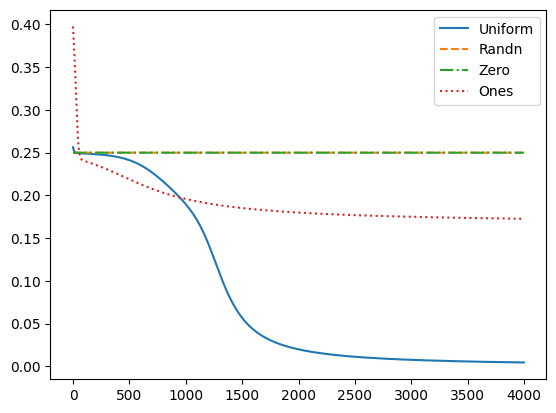

In [43]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), xornet_uniform.loss_history, label = "Uniform", linestyle="-")
plt.plot(range(epochs), xornet_randn.loss_history, label = "Randn", linestyle="--")
plt.plot(range(epochs), xornet_zero.loss_history, label = "Zero", linestyle="-.")
plt.plot(range(epochs), xornet_one.loss_history, label = "Ones", linestyle=":")

plt.legend()
plt.show()

### Effect of Initialisation

Initialisation plays one of the most important role in the performance of the model. This is made apparent in the graph above, when we compare the loss history of the different initialisation methods chosen.

* "zero" : Initialise everything as 0
* "one"  : Initialise everything as 1
* "randn": Initialise everything as randn
* "uniform": Initialise everything as uniform

Some of the most important relevation in the graph above comes from the loss history of a neural network when it is initialised. Simply put, the model does not learn, as the model is progressing to learn the same thing during backpropagation.

Notably, the normal distribution initialisation also has little improvement over time. The best perfoming is uniform, which reaches near 0 loss over the 4000 epochs. Initialising to ones learns better than zeroes but still lacks behind uniform initialisation

In [50]:
epochs = 4000
lr = 0.001
xornet_uniform_l1 = XORNetwork(x_inputs, y_classes.reshape((y_classes.shape[0], 1)), lr, epochs, init_method='uniform', reg = 'l1', r_lambda = 0.01)
xornet_uniform_l2 = XORNetwork(x_inputs, y_classes.reshape((y_classes.shape[0], 1)), lr, epochs, init_method='uniform', reg = 'l2', r_lambda = 0.01)

xornet_randn_l1 = XORNetwork(x_inputs, y_classes.reshape((y_classes.shape[0], 1)), lr, epochs, init_method='randn', reg = 'l1', r_lambda = 0.01)
xornet_randn_l2 = XORNetwork(x_inputs, y_classes.reshape((y_classes.shape[0], 1)), lr, epochs, init_method='randn', reg = 'l2', r_lambda = 0.01)

xornet_zero_11 = XORNetwork(x_inputs, y_classes.reshape((y_classes.shape[0], 1)), lr, epochs, init_method='zero', reg = 'l1', r_lambda = 0.01)
xornet_zero_l2 = XORNetwork(x_inputs, y_classes.reshape((y_classes.shape[0], 1)), lr, epochs, init_method='zero', reg = 'l2', r_lambda = 0.01)

xornet_one_l1 = XORNetwork(x_inputs, y_classes.reshape((y_classes.shape[0], 1)), lr, epochs, init_method='one', reg = 'l1', r_lambda = 0.01)
xornet_one_l2 = XORNetwork(x_inputs, y_classes.reshape((y_classes.shape[0], 1)), lr, epochs, init_method='one', reg = 'l2', r_lambda = 0.01)


xornet_uniform_l1.train()
xornet_randn_l1.train()
xornet_zero_11.train()
xornet_one_l1.train()


xornet_uniform_l2.train()
xornet_randn_l2.train()
xornet_zero_l2.train()
xornet_one_l2.train()

100%|██████████| 4000/4000 [00:31<00:00, 125.95it/s]


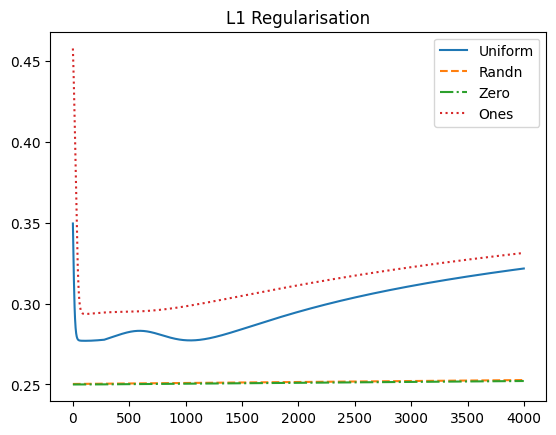

In [54]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), xornet_uniform_l1.loss_history, label = "Uniform", linestyle="-")
plt.plot(range(epochs), xornet_randn_l1.loss_history, label = "Randn", linestyle="--")
plt.plot(range(epochs), xornet_zero_11.loss_history, label = "Zero", linestyle="-.")
plt.plot(range(epochs), xornet_one_l1.loss_history, label = "Ones", linestyle=":")
plt.title("L1 Regularisation")
plt.legend()
plt.show()

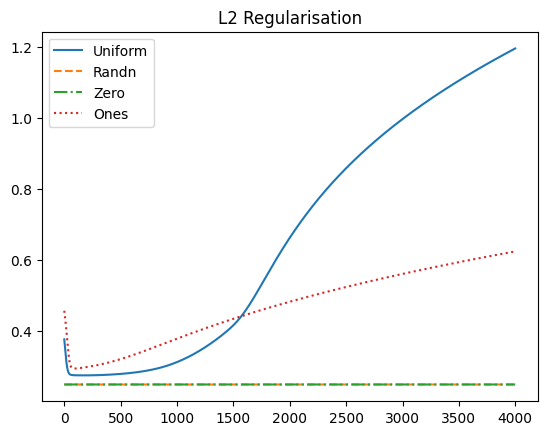

In [58]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), xornet_uniform_l2.loss_history, label = "Uniform", linestyle="-")
plt.plot(range(epochs), xornet_randn_l2.loss_history, label = "Randn", linestyle="--")
plt.plot(range(epochs), xornet_zero_l2.loss_history, label = "Zero", linestyle="-.")
plt.plot(range(epochs), xornet_one_l2.loss_history, label = "Ones", linestyle=":")
plt.title("L2 Regularisation")
plt.legend()
plt.show()

### Effect of Regularisation and Initialisation

The goal of regularisation is to dissuade the model from learning too quickly and miss the optima. As seen in our problem definition here, the L1 and L2 regularisation has drastic effects on the learning behaviour. For the experiment, we set L1 and L2 as 0.01

Predictably, zero initalisation is not effected by regularisation. However, uniform initialisation in our case does not improve the loss, infact, it explodes the loss value after a few 1000 epochs. The sudden divergence might come from the over regularisation as our the capacity of our model was just right to allow it to learn well with little to no regularisation. 

Similar to uniform, learning with 0s also does not improve over epochs as the model is simply penalising the gradient updates a lot more than necessary



***

<div class="alert alert-success" markdown="1" style="color:white; background-color: #192841; border-color: #779ecb">

> ### Going further

> The following set of questions are optionnal addendum to your previous code that allow to understand more in-depth properties about _regularization_ both for neural networks and optimization in general.

> 1. (Optional) Implement the *weight decay* constraint in your network.
> 2. (Optional) Add the *momentum* to the learning procedure.

> *Weight decay* constraint
> As nothing constrains the weights in the network, we can note that usually all weights vector given a multiplicative factor might be equivalent, which can stall the learning (and lead to exploding weights). The *weight decay* allows to regularize the learning by penalizing weights with a too wide amplitude. The idea is to add this constraint as a term to the final loss (which leads to an indirect "pressure" on the learning process. Therefore, the final loss will be defined as
> $$
{L}_{final}={L_D} + \lambda \sum_{l} \sum_{i} \sum_{j} \left( W_{ij}^{l} \right)^{2}
$$
> where the parameter $\lambda$ controls the relative importance of the two terms.

> *Momentum* in learning
> Usually, in complex problems, the gradient can be very noisy and, therefore, the learning might oscillate widely. In order to reduce this problem, we can *smooth* the different gradient updates by retaining the values of the gradient at each iteration and then performing an update based on the latest gradient $\delta_{i}^{t}$ and the gradient at the previous iteration $\delta_{i}^{t-1}$. Therefore, a gradient update is applied as
> $$
\begin{equation}
\delta_{final}^{t} = \delta_{i}^{t} + m.\delta_{i}^{t-1}
\end{equation}
$$
> with $m$ the momentum parameter, which control the amount of gradient smoothing.

</div>

***

In [ ]:

######################
# YOUR CODE GOES HERE
######################


## (Optional) 3-layer audio classification

Once again, note that the following paragraph and subsequent questions are _optional_ but should be a quite simple extension of our previous work on 2-layer networks. If you struggle with the data import mechanisms, you can look down at the PyTorch section (with a **mandatory exercise**) that will provide base code for this aspect. 

Finally, we will attack a complete audio classification problem and try to perform neural network learning on a set of audio files. The data structure will be the same as the one used for parts 1 and 2. As discussed during the courses, even though a 2-layer neural network can provide non-linear boundaries, it can not perform "holes" inside those regions. In order to obtain an improved classification, we will now rely on a 3-layer neural network. The modification to the code of section 3.2 should be minimal, as the back-propagation will be similar for the new layer as one of the two others. We do not develop the math here as it is simply a re-application of the previous rules with an additional layer (which derivatives you should have generalized in the previous exercise).  

However, up until now, we only performed *binary classification* problems, but this time we need to obtain a decision rule for multiple classes. Therefore, we cannot rely on simply computing the distance between desired patterns and the obtained binary value. The idea here is to rely on the *softmax regression*, by considering classes as a vector of probabilities. The desired answers will therefore be considered as a set of *probabilities*, where the desired class is $1$ and the others are $0$ (called *one-hot* representation). Then, the cost function will rely on the softmax formulation

$$
\begin{equation}
\mathcal{L_D}(\theta) = - \frac{1}{m} \left[ \sum_{i=1}^{m} \sum_{j=1}^{k} 1\left\{y^{(i)} = j\right\} \log \frac{e^{\theta_{j}^{T} x^{(i)}}}{\sum_{l=1}^{k} e^{ \theta_{l}^{T} x^{(i)} }}  \right]
\end{equation}
$$

Therefore, we compute the output of the softmax by taking 

$$
\begin{equation}
p(y^{(i)} = j | x^{(i)}; \theta) = \frac{e^{\theta_{j}^{T} x^{(i)}}}{\sum_{l=1}^{k} e^{ \theta_{l}^{T} x^{(i)}} }
\end{equation}
$$

By taking derivatives, we can show that the gradient of the softmax layer is

$$
\begin{equation}
\nabla_{\theta_{j}} \mathcal{L_D}(\theta) = - \frac{1}{m} \sum_{i=1}^{m}{ \left[ x^{(i)} \left( 1\{ y^{(i)} = j\}  - p(y^{(i)} = j \mid x^{(i)}, \theta) \right) \right]}
\end{equation}
$$

### Sweet activation functions

As discussed in the course, the interest of stacking layers is that there is an _activation function_, which allows non-linear interactions between the dimensions (and avoids to only compute a single huge affine transform). Although the `sigmoid` function has been historically the most used, there has been some large developments since. Notably the `ReLU` (Rectified Linear Unit) is one of the major difference in modern networks (we will see more about that in a later course)

In [ ]:
# Function for computing the Sigmoid activation
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
# Derivative
def dsigmoid(a):
    return a * (1.0 - a)
# Function for computing the ReLU activation
def relu(x):
    return np.maximum(0, x)
# Derivative
def drelu(x):
    if (x < 0):
        return 0
    return 1
# Function for computing the Tanh activation
def tanh(x):
    return np.tanh(x);
# Derivative
def dtanh(x): 
    return np.cosh(x) ^ -2

Here, we plot some simple examples of what these activation functions look like. You can try to rely on these functions in your previous training code and witness the differences in training.


In [ ]:
from bokeh.models import Div
from bokeh.layouts import column, row
from cml.plot import cml_figure
# Functions to
funcs = [('Sigmoid',sigmoid,'red'), ('Tanh',tanh,'orange'), ('ReLU',relu,'yellow')]
# Generating the x axis
x = np.linspace(-5, 5, 100)
plots = []
for (name, func, color) in funcs:
    cur_plot = cml_figure(plot_width=400, plot_height=250, title=name)
    cur_plot.line(x, func(x), color=color, line_width=4)
    plots.append(cur_plot)
plot = center_plot(column(Div(text = "Different activation functions", style={'font-size': '250%'}), row(*plots)))
plot

Row
    [0] HSpacer()
    [1] Bokeh(Column)
    [2] HSpacer()

## Coding the whole network from scratch

You should now have all the tools necessary to apply neural networks from scratch to a more complex problem. In the following exercise, we simply removed any guideline code, and you need to code all the procedure for training a NN and **apply it to audio data**. You will use the spectral features discussed in the previous exercise as an input.

***

<div class="alert alert-success" markdown="1" style="color:white; background-color: #192841; border-color: #779ecb">

> ### Going further **(optional exercise) **

>  1. Based on the previous neural network, upgrade the code to a 3-layer neural network
>  2. Implement the *softmax regression* on top of your 3-layer network
>  3. Use the provided code to perform classification on a pre-defined set of features
>  4. As previously, change the set of features to assess their different accuracies
>  5. Evaluate the neural network accuracy for all features combinations
>  6. What happens if the learning rate is too large ? What is this phenomenon ?
>  7. Perform a more advanced visualization of the learning process.
  

</div>

***

In [ ]:

######################
# YOUR CODE GOES HERE
######################


# Using `Pytorch` to enjoy life

Up to now, we have been writing every operations by ourselves (in order to better understand the mathematics behind NN). However, there exists of course some simplifying libraries that provide large simplifications to this question.

One of the most powerful and complete library of this sort is `Pytorch`, which has been developed for several years (even prior to the recent boom of deep learning). `Pytorch` provides a large set of pre-coded layers, but also **computational graphs** and **autograd**, which are very powerful paradigms allowing to define complex operators and automatically taking derivatives.

## An (extremely) fast and dirty introduction to `Pytorch`

PyTorch is a popular open-source deep learning framework based on the Torch library. It is primarily developed by Facebook AI research team, and it provides a simple and efficient way to build deep learning models. In this extremely short crash course, we will cover the basics of PyTorch, including:

* Tensors
* Automatic differentiation
* Neural networks
* Training a neural network on a dataset

For a complete tutorial on PyTorch, please check out the [official PyTorch documentation](https://pytorch.org/tutorials/). This tutorial covers a wide range of topics, including the basics of PyTorch, building and training neural networks, working with data and dataloaders, and deploying models to production.

### Tensors
At its core, PyTorch is all about tensors. A tensor is a generalization of vectors and matrices to an arbitrary number of dimensions. A scalar is a 0-dimensional tensor, a vector is a 1-dimensional tensor, and a matrix is a 2-dimensional tensor.

#### Creating Tensors
We can create a PyTorch tensor from a Python list or a NumPy array using the `torch.tensor()` function, but also tensors of a specific size and/or with all zeros or all ones using the `torch.zeros()` and `torch.ones()` functions

In [ ]:
import torch
import numpy as np
# create a tensor from a Python list
x = torch.tensor([1, 2, 3, 4])
print(x)
# create a tensor from a NumPy array
y = torch.tensor(np.array([[1, 2], [3, 4]]))
print(y)
# create a 2x3 tensor of zeros
z = torch.zeros((2, 3))
print(z)
# create a 3x2 tensor of ones
w = torch.ones((3, 2))
print(w)

tensor([1, 2, 3, 4])
tensor([[1, 2],
        [3, 4]])
tensor([[0., 0., 0.],
        [0., 0., 0.]])
tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])


#### Tensor operations

PyTorch tensors support a wide range of operations, including arithmetic operations like addition, subtraction, multiplication, and division, as well as more advanced operations like matrix multiplication, element-wise multiplication, and concatenation.

In [ ]:
# create two tensors
x = torch.tensor([1, 2, 3, 4])
y = torch.tensor([5, 6, 7, 8])
# add the two tensors
z = x + y
print(z)
# element-wise multiplication
w = x * y
print(w)
# matrix multiplication
a = torch.tensor([[1, 2], [3, 4]])
b = torch.tensor([[5, 6], [7, 8]])
c = torch.matmul(a, b)
print(c)
# concatenation
d = torch.cat((a, b), dim=1)
print(d)

tensor([ 6,  8, 10, 12])
tensor([ 5, 12, 21, 32])
tensor([[19, 22],
        [43, 50]])
tensor([[1, 2, 5, 6],
        [3, 4, 7, 8]])


### Automatic differentiation

The core of PyTorch is the autograd package. It provides automatic differentiation for all operations on Tensors.

PyTorch's autograd package provides automatic differentiation for all operations on Tensors. It is a define-by-run framework, which means that your backpropagation is defined by how your code is run, and that every single iteration can be different.

To compute gradients, the `requires_grad` property of Tensors needs to `True` (which is the case by default). This tells PyTorch to track all operations on the Tensor. You can then call `.backward()` on a Tensor to compute the gradients with respect to that Tensor.

In [ ]:
import torch

x = torch.tensor(2.0, requires_grad=True)
y = 2*x**2 + 3*x - 1
y.backward()

print(x.grad)

tensor(11.)


## Defining our network

When building neural networks we frequently think of arranging the computation into layers, some of which have learnable parameters which will be optimized during learning. In `PyTorch`, the `nn` package provides higher-level abstractions over raw computational graphs that are useful for building neural networks. The `nn` package defines a set of `Modules`, which are roughly equivalent to neural network layers. A `Module` receives input `Tensors` and computes output `Tensors`, but may also hold internal state such as `Tensors` containing learnable parameters. The nn package also defines a set of useful loss functions that are commonly used when training neural networks.

In the following example, we use the `nn` package to show how easy it is to instantiate our previous three-layers network

In [ ]:
import torch
# Define the input dimensions
in_size = 1000
# Number of neurons in a layer
hidden_size = 100
# Output (target) dimension
output_size = 10
# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
    torch.nn.Linear(in_size, hidden_size),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_size, hidden_size),
    torch.nn.Tanh(),
    torch.nn.Linear(hidden_size, output_size),
    torch.nn.Softmax(dim=1)
)

### Optimizing the network

Up to this point we have updated the weights of our models by manually performing the gradient descent algorithm (changing the parameters vectors). Although this is not a huge burden for simple optimization algorithms like stochastic gradient descent, in practice we often train neural networks using more sophisticated optimizers like AdaGrad, RMSProp or Adam (that we will see later in this course)

The `optim` package in PyTorch abstracts the idea of an optimization algorithm and provides implementations of commonly used optimization algorithms, and greatly simplfies the training loop associated with training a neural network.

For the sake of presentation we will use random inputs $\mathbf{x}$ that should be matched with random outputs $\mathbf{y}$

In [ ]:
batch_size = 64
# Create random Tensors to hold inputs and outputs
x = torch.randn(batch_size, in_size)
y = torch.randn(batch_size, output_size)

In the following example we optimize the model using the Adam algorithm provided by the `optim` package, based on a `MSE` loss.

In [ ]:
# Learning rate
learning_rate = 1e-4
# Loss function that we will use
loss_fn = torch.nn.MSELoss(reduction='sum')
# Optimizer to fit the weights of the network
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)
    # Compute the loss.
    loss = loss_fn(y_pred, y)
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
print(loss)
    

tensor(623.4047, grad_fn=<MseLossBackward0>)


## Exercise 2 - Pytorch to classify audio

Now that we know the main components of `Pytorch` to define and optimize networks, your assignement is to define a complete classification problem from audio data, by relying on this toolbox

***

<div class="alert alert-success" markdown="1" style="color:white; background-color: #013220; border-color: #03C03C">

> ### Question 1.1 - Model and definition

>   1. Use `Pytorch` to define a model for audio classification
>   2. Import the audio features dataset and check that your model produces an output

</div>

***


In [4]:
!wget https://nubo.ircam.fr/index.php/s/ByK4QL7nE4Mq5MA/download/musclefish.zip
!unzip musclefish.zip
!mkdir data
!mv musclefish data/

--2023-05-18 03:33:08--  https://nubo.ircam.fr/index.php/s/ByK4QL7nE4Mq5MA/download/musclefish.zip
Resolving nubo.ircam.fr (nubo.ircam.fr)... 129.102.1.87, 2001:660:3004:4001::87:666
Connecting to nubo.ircam.fr (nubo.ircam.fr)|129.102.1.87|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3080254 (2.9M) [application/zip]
Saving to: ‘musclefish.zip’

musclefish.zip      100%[===================>]   2.94M  2.06MB/s    in 1.4s    

2023-05-18 03:33:11 (2.06 MB/s) - ‘musclefish.zip’ saved [3080254/3080254]

Archive:  musclefish.zip
   creating: musclefish/
  inflating: __MACOSX/._musclefish   
   creating: musclefish/bells/
  inflating: __MACOSX/musclefish/._bells  
  inflating: musclefish/.DS_Store    
  inflating: __MACOSX/musclefish/._.DS_Store  
   creating: musclefish/speech.male/
  inflating: __MACOSX/musclefish/._speech.male  
   creating: musclefish/water/
  inflating: __MACOSX/musclefish/._water  
   creating: musclefish/oboe/
  inflating: __MACOSX/musclefi

In [5]:
from cml.data import import_dataset, AudioSupervisedDataset
data_path = "data/"
batch_size = 16
# Instantiate the dataset class
train_dataset = import_dataset(data_path, "musclefish", 'train', batch_size=batch_size)
# Generate a batch of data from the train dataset
batch_x, batch_y = next(train_dataset)
# Print the shape of the input and output batch tensors
print(batch_x.shape)  # (16, 44100)
print(batch_y.shape)  # (16,)

Recursive search in data//musclefish
(16, 44100)
(16,)


In [6]:
from sklearn.model_selection import train_test_split

# Split the dataset into train and test by index
X_train_index, X_test_index, y_train, y_test = train_test_split(
    np.arange(len(train_dataset.labels)), train_dataset.labels, test_size=0.1, stratify=train_dataset.labels, random_state=100)

In [7]:
# !pip uninstall matplotlib librosa
# !pip install librosa==0.8.0
# !pip install matplotlib==3.3.4

In [23]:
# using features
import torch

def get_features(index, kind = 'raw'):
  if kind == 'raw':
    return train_dataset.audio[index]
  elif kind == 'all_features_mean':
    feats = []
    feats.append(train_dataset.feature(index, "loudness"))
    feats.append(train_dataset.feature(index, "centroid"))
    feats.append(train_dataset.feature(index, "bandwidth"))
    feats.append(train_dataset.feature(index, "contrast"))
    feats.append(train_dataset.feature(index, "flatness"))
    feats.append(train_dataset.feature(index, "rolloff"))

    all_means = np.array([np.mean(feat) for feat in feats])
    return all_means
  elif kind == 'all_features_std':
    feats = []
    feats.append(train_dataset.feature(index, "loudness"))
    feats.append(train_dataset.feature(index, "centroid"))
    feats.append(train_dataset.feature(index, "bandwidth"))
    feats.append(train_dataset.feature(index, "contrast"))
    feats.append(train_dataset.feature(index, "flatness"))
    feats.append(train_dataset.feature(index, "rolloff"))

    all_stds = np.array([np.std(feat) for feat in feats])
    return all_stds
  elif kind == 'all_features':
    feats = []
    feats.append(train_dataset.feature(index, "loudness"))
    feats.append(train_dataset.feature(index, "centroid"))
    feats.append(train_dataset.feature(index, "bandwidth"))
    feats.append(train_dataset.feature(index, "contrast"))
    feats.append(train_dataset.feature(index, "flatness"))
    feats.append(train_dataset.feature(index, "rolloff"))

    all_both = np.array([np.std(feat) for feat in feats])
    all_both = np.concatenate([all_both, np.array([np.mean(feat) for feat in feats])])
    return all_both

In [24]:
# feature set
raw_train = np.array([get_features(index) for index in X_train_index])
raw_test = np.array([get_features(index) for index in X_test_index])

mean_train = np.array([get_features(index, 'all_features_mean') for index in X_train_index])
mean_test = np.array([get_features(index, 'all_features_mean') for index in X_test_index])

std_train = np.array([get_features(index, 'all_features_std') for index in X_train_index])
std_test = np.array([get_features(index, 'all_features_std') for index in X_test_index])

both_train = np.array([get_features(index, 'all_features') for index in X_train_index])
both_test = np.array([get_features(index, 'all_features') for index in X_test_index])

y_train = np.array(y_train)
y_test = np.array(y_test)

In [25]:
# import tensorflow as tf

# raw_train_ds = tf.data.Dataset.from_tensor_slices((raw_train, y_train))
# raw_test_ds = tf.data.Dataset.from_tensor_slices((raw_test, y_test))

# mean_train_ds = tf.data.Dataset.from_tensor_slices((mean_train, y_train))
# mean_test_ds = tf.data.Dataset.from_tensor_slices((mean_test, y_test))

# std_train_ds = tf.data.Dataset.from_tensor_slices((std_train, y_train))
# std_test_ds = tf.data.Dataset.from_tensor_slices((std_test, y_test))

In [26]:
# creating dataloader

batch_size = 20

# CHANGE DATASET HERE
ds = both_train
ds_test = both_test

train_dataloader = torch.utils.data.DataLoader(
    list(zip(ds, y_train)),
    batch_size=batch_size,
    num_workers=2,
    shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    list(zip(ds_test, y_test)),
    batch_size=batch_size,
    num_workers=2,
    shuffle=True
)

### Defining the Model

In [27]:
next(iter(ds)).shape

(12,)

In [29]:
# Define the input dimensions
in_size = next(iter(ds)).shape[0]
# Number of neurons in a layer
# Due to the relatively high number of features, we can apply
# 2-3 hidden layers
hidden_size_1 = 2024
hidden_size_2 = 1024
hidden_size_3 = 512
hidden_size_4 = 100
# Output (target) dimension (16 classes)
output_size = 16
# Use the nn package to define our model and loss function.
# We are using ReLU activation function here
# And softmax for multi-class classification
model = torch.nn.Sequential(
    torch.nn.Linear(in_size, hidden_size_1),
    torch.nn.BatchNorm1d(hidden_size_1),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size_1, hidden_size_2),
    torch.nn.BatchNorm1d(hidden_size_2),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size_2, hidden_size_3),
    torch.nn.BatchNorm1d(hidden_size_3),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size_3, hidden_size_4),
    torch.nn.BatchNorm1d(hidden_size_4),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size_4, output_size),
    torch.nn.Softmax(dim=1)
)


***

<div class="alert alert-success" markdown="1" style="color:white; background-color: #013220; border-color: #03C03C">

> ### Question 1.2 - Training the model

>   3. Write the optimization loop (think carefully about the _loss function_
>   4. As previously, change the set of features to assess their different accuracies
>   5. (Optional) Think of how you could use more complex features (time series, audio, STFT) to classify your data

</div>

***

In [ ]:
import tensorflow as tf
# Learning rate
learning_rate = 1e-4
# Loss function that we will use
loss_fn = torch.nn.CrossEntropyLoss()
# Optimizer to fit the weights of the network
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# Number of Epochs
n_iter = 500
train_dataset._reset_generator()


for t in range(n_iter):

  for batch, (batch_x, batch_y) in enumerate(train_dataloader):
      model.train()
      # Forward pass: compute predicted y by passing x to the model.
      batch_x = torch.FloatTensor(batch_x.numpy())
      batch_y = torch.LongTensor(batch_y.numpy())
      y_pred = model(batch_x)
      # Compute the loss
      loss = loss_fn(y_pred, batch_y)
      # Before the backward pass, zero all of the network gradients
      optimizer.zero_grad()
      # Backward pass: compute gradient of the loss with respect to parameters
      loss.backward()
      # Calling the step function to update the parameters
      optimizer.step()

      # if batch % 10 == 0:
      #   loss, current = loss.item(), batch * len(batch_x)
      #   print(f'loss: {loss:>7f}  [{current:>5d}/{len(ds):>5d}]')
    
  model.eval()
  test_loss, correct = 0, 0
  size = len(test_dataloader.dataset)
  with torch.no_grad():
      for batch, (batch_x, batch_y) in enumerate(test_dataloader):
          # X, Y = X.to(device), Y.to(device)
          batch_x = torch.FloatTensor(batch_x.numpy())
          batch_y = torch.LongTensor(batch_y.numpy())
          pred = model(batch_x)

          test_loss += loss_fn(pred, batch_y).item()
          correct += (pred.argmax(1)==batch_y).type(torch.float).sum().item()
      
      test_loss /= size
      correct /= size

  if t % 100 == 0:
    print(f'Epoch: {t}')
    print(f'Train loss: {loss:>7f}')
    print(f'\nTest Error:\nacc: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f}\n')    

print(f'Epoch: {t}')
print(f'Train loss: {loss:>7f}')
print(f'\nTest Error:\nacc: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f}\n')    

### Effect of feature selection
We trained the model with 1000 epochs and a learning rate of 1e-4. Since this is a classification model, we use CrossEntropyLoss to calculate the loss value. To understand how the model performs with feature selection, we trained and noted the model accuracy at the following situations:

| Method       | Best Accuracy |
|--------------|---------------|
| Raw Features | 32.9%         |
| Only Mean    | 56.1%         |
| Only STD     | 45.1%         |
| Both         | 61%           |

Here Raw features refers to training using the original 44,100 features of the audio samples as floating point features. As we can see, using both mean and standard deviations of 6 features of the model, we are able to reach a maximum of 61% accuracy on the model with little hyperparameter tuning.

When we tried reducing the set of the features, we found that the model inturn performed poorer than the whole feature set. Notably, using batch normalisation helped us converge faster and stabilised the learning path
